In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBRegressor
from datetime import datetime, timedelta

In [2]:
uri = f'postgres://localhost/food_company'
engine = create_engine(uri, echo=False)

In [3]:
query = """
        SELECT  train.week, train.num_orders, 
            meal_info.cuisine, fullfilment_info.city_code
        FROM train 
        JOIN meal_info
            ON train.meal_id = meal_info.meal_id
        JOIN fullfilment_info 
            ON train.center_id = fullfilment_info.center_id
        WHERE train.center_id=43 AND train.meal_id=2290;
        """

In [4]:
data = pd.read_sql(query, engine)
data = data.sort_values("week", ascending=True)

# Include Timestemp

In [5]:
period = len(data)

data['Date'] = pd.date_range('2018-07-23', periods=period, freq='W')

data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Quarter'] = data['Date'].dt.quarter

data = data.set_index(['Date'])

In [6]:
data.head()

,week,num_orders,cuisine,city_code,Day,Month,Year,Quarter
Date,,,,,,,,
2018-07-29,1,944,Indian,590,29,7,2018,3
2018-08-05,2,1052,Indian,590,5,8,2018,3
2018-08-12,3,1081,Indian,590,12,8,2018,3
2018-08-19,4,1243,Indian,590,19,8,2018,3
2018-08-26,5,24299,Indian,590,26,8,2018,3


# Total orders per week

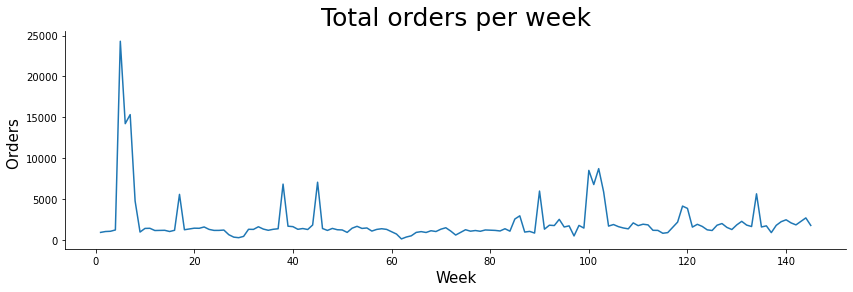

In [7]:
plt.figure(figsize=(14, 4))
total_order = sns.lineplot( data=data, 
                    x="week", 
                    y="num_orders")
total_order.set_title(label="Total orders per week", loc='center', fontdict={'fontsize':25})
plt.xlabel("Week", size=15)
plt.ylabel("Orders ", size=15)
sns.despine()

# Train test split

In [8]:
data = data.drop(axis=1, columns="cuisine")

In [9]:
x_train = data.drop(columns='num_orders')
y_train = data['num_orders']
y_train = np.log1p(y_train)
split_size = period-20
X_train = x_train.iloc[:split_size,:]
X_test = x_train.iloc[split_size:,:]
Y_train =  y_train.iloc[:split_size]
Y_test = y_train.iloc[split_size:]

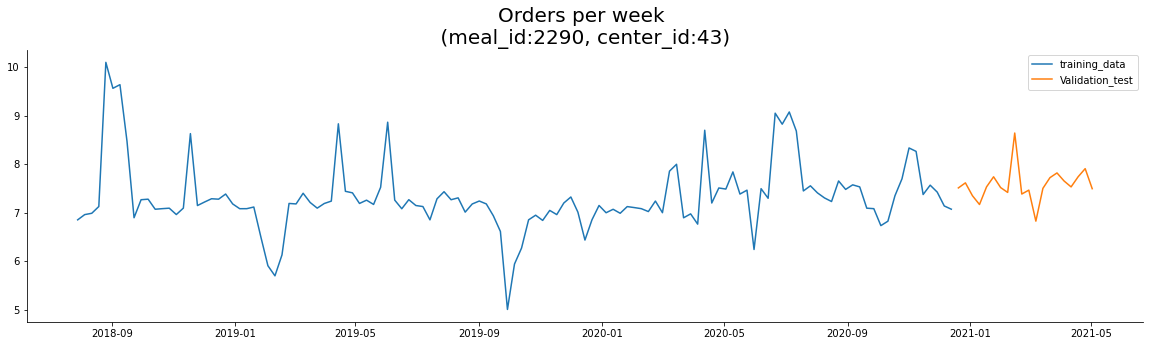

In [10]:
plt.figure(figsize=(20,5))
plt.title('Orders per week \n (meal_id:2290, center_id:43) ',fontdict={'fontsize':20})
plt.plot(Y_train, label='training_data')
plt.plot(Y_test, label='Validation_test')
plt.legend(loc='best')
sns.despine()
plt.savefig('../figs/train_test.pdf')

# ARIMA

In [11]:
Y_train

Date
2018-07-29     6.851185
2018-08-05     6.959399
2018-08-12     6.986566
2018-08-19     7.126087
2018-08-26    10.098232
                ...    
2020-11-15     7.373374
2020-11-22     7.566311
2020-11-29     7.422971
2020-12-06     7.137278
2020-12-13     7.070724
Name: num_orders, Length: 125, dtype: float64

In [12]:
Y_train_dif_1 = Y_train.diff().fillna(Y_train)
Y_train_dif_2 = Y_train_dif_1.diff().fillna(Y_train_dif_1)
Y_train_dif_3 = Y_train_dif_2.diff().fillna(Y_train_dif_2)

In [13]:
result = adfuller(Y_train_dif_1, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -7.772612810471023
n_lags: 8.838605820712801e-12
p-value: 8.838605820712801e-12
Critial Values:
   1%, -3.4865346059036564
Critial Values:
   5%, -2.8861509858476264
Critial Values:
   10%, -2.579896092790057


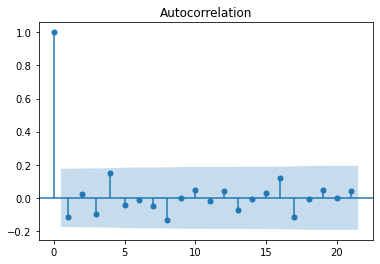

In [14]:
acf = plot_acf(Y_train_dif_1)

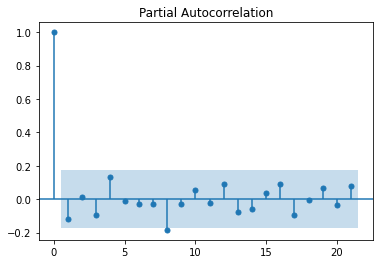

In [15]:
pacf = plot_pacf(Y_train_dif_1)

In [16]:
arima = ARIMA(Y_train.values, order=(2,1,1))
arima_model = arima.fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

In [17]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  124
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -111.092
Method:                       css-mle   S.D. of innovations              0.585
Date:                Wed, 05 May 2021   AIC                            232.183
Time:                        19:01:35   BIC                            246.285
Sample:                             1   HQIC                           237.912
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.004      0.270      0.787      -0.006       0.008
ar.L1.D.y      0.5734      0.090      6.388      0.000       0.397       0.749
ar.L2.D.y      0.0335      0.090      0.374      0.708      -0.142       0.209
ma.L1.D.y     -1.0000      0.028    -35.807      0.000      -1.055      -0.945
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5953           +0.0000j            1.5953            0.0000
AR.2          -18.7071           +0.0000j           18.7071            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [18]:
arima_preds = arima_model.predict(typ='levels')
arima_preds

array([6.8521439 , 6.93568245, 6.96339402, 7.06709597, 9.14338456,
       8.98185497, 9.07122197, 8.35243017, 7.2902873 , 7.44897172,
       7.45612723, 7.31265687, 7.2986658 , 7.29320254, 7.20034538,
       7.26705972, 8.21956167, 7.37059613, 7.3558291 , 7.3946299 ,
       7.3873187 , 7.44808769, 7.32477899, 7.25292577, 7.24442719,
       7.25985128, 6.88224216, 6.49070938, 6.32719812, 6.56231711,
       7.20332423, 7.23288932, 7.36372515, 7.25791241, 7.1810462 ,
       7.23267587, 7.26469652, 8.21838822, 7.45573857, 7.39023713,
       7.25957867, 7.2914643 , 7.24075728, 7.44732866, 8.25815801,
       7.36230097, 7.20096128, 7.30375512, 7.23854935, 7.22045516,
       7.05614181, 7.30011406, 7.40134239, 7.30955922, 7.32632575,
       7.15396323, 7.24135294, 7.28211936, 7.24852797, 7.10150293,
       6.90122124, 5.93966178, 6.42298163, 6.64104345, 6.98928314,
       7.06347946, 7.00223904, 7.1179148 , 7.07348269, 7.20958387,
       7.29077033, 7.11204617, 6.76342842, 6.98581349, 7.17101

In [19]:
arima_preds = pd.DataFrame(arima_preds[:20])
arima_preds.index = Y_test.index
arima_preds = np.exp(arima_preds)

# XGBoost

In [20]:
try_xgboost = XGBRegressor(learning_rate = 0.01,
    eval_metric ='rmse',
    n_estimators = 50000,
    max_depth = 7,
    subsample = 0.5,
    colsample_bytree = 1,
    gamma = 0.5
    )

In [21]:
try_xgboost.fit(X_train, Y_train, 
    eval_metric='rmse', 
    eval_set=[(X_test, Y_test)], 
    early_stopping_rounds=500, 
    verbose=100)

[0]	validation_0-rmse:7.01845
[100]	validation_0-rmse:2.79601
[200]	validation_0-rmse:1.25627
[300]	validation_0-rmse:0.69287
[400]	validation_0-rmse:0.50299
[500]	validation_0-rmse:0.42645
[600]	validation_0-rmse:0.40958
[700]	validation_0-rmse:0.40181
[800]	validation_0-rmse:0.39712
[900]	validation_0-rmse:0.39739
[1000]	validation_0-rmse:0.39720
[1100]	validation_0-rmse:0.39427
[1200]	validation_0-rmse:0.39233
[1300]	validation_0-rmse:0.39250
[1400]	validation_0-rmse:0.39221
[1500]	validation_0-rmse:0.39555
[1600]	validation_0-rmse:0.39558
[1700]	validation_0-rmse:0.39806
[1800]	validation_0-rmse:0.39798
[1812]	validation_0-rmse:0.39791


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0.5, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50000, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [22]:
best = (try_xgboost.get_booster().best_iteration)
xgboost_model = XGBRegressor(
    learning_rate = 0.01,
    n_estimators = best,
    max_depth = 5,
    subsample = 0.5,
    colsample_bytree = 1,
    gamma = 0.5)
xgboost_model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1312, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
xgboost_preds = xgboost_model.predict(X_test)
xgboost_preds = np.exp(xgboost_preds)
xgboost_preds

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([1734.4995, 1820.519 , 1338.9918, 1743.5406, 1505.9464, 1650.5966,
       1088.0934, 1633.8523, 1760.0378, 1548.973 , 1598.1838, 2142.9875,
       2225.9258, 1909.6816, 1961.9583, 1954.5917, 2551.624 , 1993.8024,
       2151.806 , 2608.8887], dtype=float32)

In [24]:
xgboost_preds = pd.DataFrame(xgboost_preds)
xgboost_preds.index = Y_test.index

In [25]:
xgboost_preds

,0
Date,
2020-12-20,1734.499512
2020-12-27,1820.519043
2021-01-03,1338.991821
2021-01-10,1743.540649
2021-01-17,1505.946411
2021-01-24,1650.596558
2021-01-31,1088.093384
2021-02-07,1633.852295
2021-02-14,1760.037842


In [26]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)

# Plot for the predictions

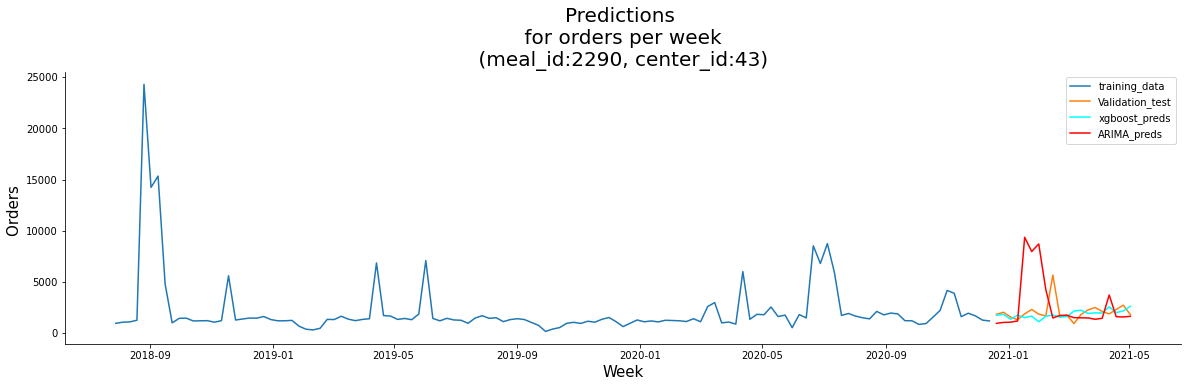

In [27]:
plt.figure(figsize=(20,5))
plt.title('Predictions \n for orders per week \n (meal_id:2290, center_id:43) ',fontdict={'fontsize':20})
plt.xlabel("Week", size=15)
plt.ylabel("Orders ", size=15)
plt.plot(Y_train, label='training_data')
plt.plot(Y_test, label='Validation_test')
plt.plot(xgboost_preds, color='cyan', label='xgboost_preds')
plt.plot(arima_preds, color='red', label='ARIMA_preds')
plt.legend(loc='best')
sns.despine()
plt.savefig('../figs/prediction.pdf')

In [28]:
xgboost_preds

,0
Date,
2020-12-20,1734.499512
2020-12-27,1820.519043
2021-01-03,1338.991821
2021-01-10,1743.540649
2021-01-17,1505.946411
2021-01-24,1650.596558
2021-01-31,1088.093384
2021-02-07,1633.852295
2021-02-14,1760.037842


In [29]:
arima_preds.head()

,0
Date,
2020-12-20,945.906662
2020-12-27,1028.320785
2021-01-03,1057.215690
2021-01-10,1172.737421
2021-01-17,9352.365255
